<a href="https://colab.research.google.com/github/Heity94/WalkieLookie/blob/main/notebooks/PH_Route_within_timeframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install requirements { display-mode: "form" }
!pip install osmnx
!pip install networkx
!pip install geopy

❗**Attention**: In order to make the code work you need to **restart your runtime** afer executing the cell above ☝ (not just reloading the web page).<br> 
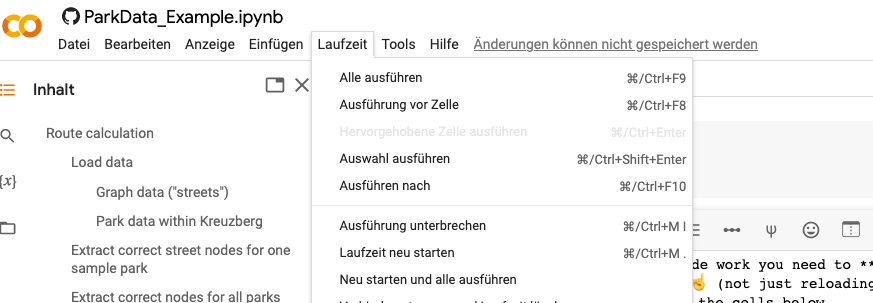
<br>
After that you can continue with running the cells below 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title Imports
import pickle
import folium
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
from geopy.geocoders import Nominatim
from networkx.algorithms import approximation as approx # Greedy salesman algorithms

In [5]:
# Link to common google drive folder (you have to add a link from the foder to your drive first)
data_path = "/content/drive/MyDrive/BPI Lap WalkieLookie/Data/"
#data_path = "/content/drive/MyDrive/WalkieLookie/BPI Lap WalkieLookie/Data" #Roger

# Preprocess Berlin park nodes

In [6]:
from networkx.algorithms import approximation as approx

In [7]:
bln_xberg_wo_NaN = pd.read_csv(data_path+"/bln_xberg_parks_park_nodes_wo_NaN.csv", index_col=0)

In [8]:
#load stored graph pickle file
with open(data_path+'graph_bln_kzb.obj', 'rb') as fp:
  graph_bln_kzb = pickle.load(fp)

In [9]:
#load stored graph pickle file
#with open(data_path+'/graph_berlin.obj', 'rb') as fp:
#  graph_berlin = pickle.load(fp)

In [ ]:
bln_xberg_wo_NaN = pd.read_csv(data_path+"/bln_xberg_parks_park_nodes_wo_NaN.csv", index_col=0)

In [10]:
from ast import literal_eval

#Change type to list
bln_xberg_wo_NaN["nodes_within_park"]=bln_xberg_wo_NaN.nodes_within_park.apply(lambda x: literal_eval(x))

In [11]:
# Store nodes of Berlin Graph (Streets) -> storage as set is way fatser than lists!!!!
gr_bln = set(graph_bln_kzb.nodes())

In [12]:
%%time
# Create column whihc only includes nodes which are also within the berlin graph dats (streets)
bln_xberg_wo_NaN["park_nodes_within_graph"] = bln_xberg_wo_NaN.nodes_within_park.apply(lambda x: [node for node in x if node in gr_bln])

CPU times: user 4.55 ms, sys: 0 ns, total: 4.55 ms
Wall time: 5.54 ms


In [13]:
bln_xberg_wo_NaN.head(3)

,osmid,name,nodes_within_park,park_nodes_within_graph
0,4638994.0,Viktoriapark,"[7086354702, 7086354703, 7086354704, 708635470...","[241490617, 401579047, 2022056010, 1977632074,..."
1,12773361.0,NaN,"[710862331, 3411068721, 9582743421, 710862332,...","[710862331, 3411068721, 9582743421, 710862332,..."
2,13853629.0,Körnerpark,"[9311122713, 9238292155, 1455122375, 145512220...",[]


In [14]:
# Check length of list of park_nodes_within_graph
bln_xberg_wo_NaN.park_nodes_within_graph.apply(lambda x: len(x)).sort_values()

70       0
36       0
37       0
97       0
92       0
      ... 
40     114
137    138
114    203
3      285
0      333
Name: park_nodes_within_graph, Length: 133, dtype: int64

Some parks (very small ones) do not have streets in them. We have to filter out these "empty rows"

In [15]:
# Remove rows which have a length of 0
bln_xberg_wo_NaN_cln = bln_xberg_wo_NaN[bln_xberg_wo_NaN.park_nodes_within_graph.apply(lambda x: len(x)) > 0].copy()

In [16]:
# Function to calculate center node (if possible), otherwise retunr "No center found"
def center_nodes(x):
  try: 
    return nx.center(graph_bln_kzb.subgraph(x))[0] #take first center node (in case there are more than 1)
  except:
    return "No center found"

In [17]:
# Get center node for each park
bln_xberg_wo_NaN_cln["center_node"] = bln_xberg_wo_NaN_cln.park_nodes_within_graph.apply(lambda x: center_nodes(x))

In [18]:
bln_xberg_wo_NaN_cln.head(3)

,osmid,name,nodes_within_park,park_nodes_within_graph,center_node
0,4638994.0,Viktoriapark,"[7086354702, 7086354703, 7086354704, 708635470...","[241490617, 401579047, 2022056010, 1977632074,...",330288907
1,12773361.0,NaN,"[710862331, 3411068721, 9582743421, 710862332,...","[710862331, 3411068721, 9582743421, 710862332,...",3411068721
3,15740772.0,Görlitzer Park,"[5630371451, 5630371452, 5630371453, 563037145...","[122087881, 32248759, 157467514, 5630372655, 6...",383277458


In [19]:
# For 10 parks there could not be a center found
bln_xberg_wo_NaN_cln.center_node.value_counts().head(2)

No center found    8
791390982          3
Name: center_node, dtype: int64

In [20]:
# Store file as .csv
#bln_xberg_wo_NaN_cln.to_csv(data_path+"/bln_xberg_parks_park_nodes_wo_NaN_with_center.csv")

# Create route which fits within user timeframe

In [21]:
# filter out parks without center (for now)
bln_xberg_wo_NaN_cln = bln_xberg_wo_NaN_cln[bln_xberg_wo_NaN_cln.center_node!="No center found"].copy()

In [22]:
#select three parks
prks_sample = bln_xberg_wo_NaN_cln[bln_xberg_wo_NaN_cln.osmid.isin([1065171552.0, 4638994.0, 45115505.0])]

In [23]:
# Select center park nodes
parks_to_visit = prks_sample.loc[:,"center_node"].to_list()

In [24]:
# find shortest path based on distance or time
optimizer = 'length'        # 'length','time'

#  find the shortest path
shortest_route = nx.shortest_path(graph_bln_kzb,
                                  parks_to_visit[0],
                                  parks_to_visit[1],
                                  weight=optimizer)

In [25]:
#plot combined route
ox.plot_route_folium(graph_bln_kzb, shortest_route)

Using the traveling salesman problem function on the complete graph data of Berlin Kreuzberg the code runs forever until it eventually kills my notebook because of RAM???

In [25]:
#%%time
#TSM_path = approx.traveling_salesman_problem(graph_bln_kzb, nodes=parks_to_visit, weight="length", cycle=False)#, method=method, weight="length")

Lets try out if a smaller graph solves the problem

In [36]:
# Download smaller graph which hardly contains the three parks
#test_graph = ox.graph.graph_from_address("Zossener Straße 11, 10961 Berlin", dist=1000, network_type='walk')
#with open('/content/drive/MyDrive/graph_berlin_kzb_small.obj', 'wb') as fp:
#  pickle.dump(test_graph, fp)

#load stored graph pickle file
with open('/content/drive/MyDrive/graph_berlin_kzb_small.obj', 'rb') as fp:
  test_graph = pickle.load(fp)


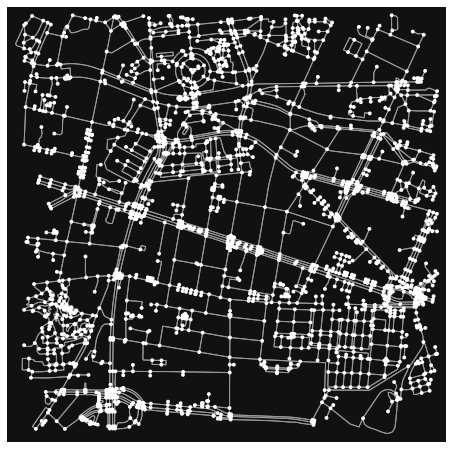

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [37]:
# Lets plot the map
ox.plot_graph(test_graph)

In [28]:
%%time
TSM_path = approx.traveling_salesman_problem(test_graph, nodes=parks_to_visit, weight="length", cycle=False)

CPU times: user 52.7 s, sys: 2.18 s, total: 54.9 s
Wall time: 55.2 s


At least this time it worked, but still it took almost a minute to calculate the route

In [67]:
# Sum up travel time and distance
cols = ['osmid', 'length']#, 'travel_time']
attrs = ox.utils_graph.get_route_edge_attributes(test_graph, TSM_path)
df_route = pd.DataFrame(attrs)[cols]
print("Total lenght [m]:", df_route.length.sum().round(2))
print("Predicted travel time in minutes for an avg. speed of 5km/h:", round((df_route.length.sum()/5000)*60))

Total lenght [m]: 2151.9
Predicted travel time in minutes for an avg. speed of 5km/h: 26


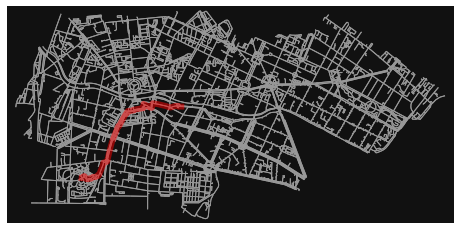

In [34]:
#plot route on the berlin kreuzberg full map
ox.plot_graph_route(graph_bln_kzb, TSM_path, route_color="red", route_linewidth=6, node_size=0, orig_dest_size=0);

In [35]:
#Plot route whch passes by all parks with folium
TSM_map = ox.plot_route_folium(graph_bln_kzb, TSM_path)

# Add markers of parks
for i, park in enumerate(parks_to_visit):
  latlng_parks = (graph_bln_kzb.nodes()[park]["y"], graph_bln_kzb.nodes()[park]["x"])
  marker = folium.Marker(
              location = latlng_parks,
              icon = folium.Icon(color='green'))

  marker.add_to(TSM_map)
TSM_map

If we do not manage to get the algorithm working on a bigger graph (like Kreuzberg or all streets within the ring, we would probably need to download a smaller version of the graph based on the user start location and some radius (based on time). This of course would also slow down our proces quiet a bit ....

In [85]:
user_time = 60 #minutes
avg_speed = 5 #km/s

def get_searchradius(user_time, avg_speed=5): 
  '''Calculate search radius for parks and graphs based on the user time and average speed'''

  radius = (avg_speed*1000/60)*user_time

  return radius

In [48]:
def load_street_graph(start_address, radius, end_address=None):

  street_graph = ox.graph.graph_from_address(start_address, dist=radius, network_type='walk')
  
  return street_graph

In [79]:
# Function to calculate center node (if possible), otherwise retunr "No center found"
def center_nodes(street_graph, places_nodes_on_map):
  try: 
    return nx.center(street_graph.subgraph(places_nodes_on_map))[0] #take first center node (in case there are more than 1)
  except:
    return "No center found"

In [81]:
from ast import literal_eval

#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"/bln_xberg_parks_park_nodes_wo_NaN.csv", index_col=0)
places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

def get_noi(street_graph, places_noi):

  street_nodes = set(street_graph.nodes())

  # Create column whihc only includes nodes which are also within the berlin graph dats (streets)
  places_noi["park_nodes_within_graph"] = places_noi.nodes_within_park.apply(lambda x: [node for node in x if node in street_graph])

  places_noi = places_noi[places_noi.park_nodes_within_graph.apply(lambda x: len(x)) > 0] #Filter out empty parks

  # Get center node for each park
  places_noi["center_node"] = places_noi.park_nodes_within_graph.apply(lambda x: center_nodes(street_graph, x))

  # filter out parks without center (for now)
  places_noi = places_noi[places_noi.center_node!="No center found"].copy()

  # Select center park nodes and store as list for route planning
  nodes_to_visit = places_noi.loc[:,"center_node"].to_list()

  return places_noi, nodes_to_visit

In [76]:
def add_start_end_node(start_address, street_graph, nodes_to_visit, end_address=None):
  '''Add start (and end address) to list of nodes which should be visited'''

  locator = Nominatim(user_agent = "myapp")

  # stores the start and end points as geopy.point.Point objects
  start_latlng = locator.geocode(start_address).point
  #end_latlng = locator.geocode(end_location).point

  orig_node = ox.distance.nearest_nodes(street_graph, start_latlng[1], start_latlng[0]) #graph, long, lat

  nodes_to_visit = [orig_node]+nodes_to_visit #add start node tto list to visit

  return nodes_to_visit

In [82]:
def caculate_route(street_graph, nodes_to_visit, cycle=True):

  calc_route = approx.traveling_salesman_problem(street_graph, nodes=nodes_to_visit, weight="length", cycle=cycle)

  return calc_route

In [77]:
def get_route_stats(calc_route, street_graph):
  '''Get total length and travel time of calculated route'''
    
  # Sum up travel time and distance
  cols = ['osmid', 'length']#, 'travel_time']
  attrs = ox.utils_graph.get_route_edge_attributes(street_graph, calc_route)
  df_route = pd.DataFrame(attrs)[cols]
  
  length_m = df_route.length.sum().round().astype("int")
  travel_time_min = round((df_route.length.sum()/5000)*60)

  return length_m, travel_time_min

### Try out functions

In [1]:
# User inut
user_time = 10 #minutes
start_address = "Zossener Straße 11, 10961 Berlin"
round_trip=True

In [2]:
#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"/bln_xberg_parks_park_nodes_wo_NaN.csv", index_col=0)
places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

NameError: ignored

In [ ]:
# Let all functions run
radius = get_searchradius(user_time, avg_speed)
street_graph = load_street_graph(start_address, radius)
places_noi, nodes_to_visit = get_noi(street_graph, places_noi)
nodes_to_visit_final = add_start_end_node(start_address, street_graph, nodes_to_visit)
calc_route = caculate_route(street_graph, nodes_to_visit_final, round_trip)
length_m, travel_time_min = get_route_stats(calc_route, street_graph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


So the functions seems to work and it run in 